# 1. Import Libraries

---


In [5]:
# Prep
import pandas as pd
from sklearn.model_selection import train_test_split

# Utility
import numpy as np
from sklearn.gaussian_process.kernels import RBF
import warnings

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score

warnings.filterwarnings('ignore')

# 2. Visualize Data

---


In [6]:
df = pd.read_csv("CADE.csv")

In [7]:
numerical_columns = ["Age", "Weight", "Length", "BMI", "BP", "PR", "FBS", "CR", "TG", "LDL", "HDL",	"BUN", "ESR", "HB",	"K", "Na", "WBC", "Lymph", "Neut", "PLT", "EF-TTE"]
categorical_columns = ["Sex", "DM", "HTN", "Current Smoker", "EX-Smoker", "FH", "Obesity", "CRF", "CVA", "Airway disease", "Thyroid Disease", "CHF", "DLP", "Edema", "Weak Peripheral Pulse", "Lung rales", "Systolic Murmur", "Diastolic Murmur", "Typical Chest Pain", "Dyspnea", "Function Class", "Atypical", "Nonanginal", "Exertional CP", "LowTH Ang", "Q Wave", "St Elevation", "St Depression", "Tinversion", "LVH", "Poor R Progression", "VHD", "Cath", "BBB", "LAD", "LCX", "RCA"]

In [8]:
# Categorical Values unique values
print("=="*30)
print(f'Total Categorical Variables = {len(categorical_columns)}')
print("=="*30)
for cat_col in categorical_columns:
  print(f'* {cat_col} ==> {df[cat_col].unique()} ==> {df[cat_col].nunique()} unique values')

Total Categorical Variables = 37
* Sex ==> ['Male' 'Fmale'] ==> 2 unique values
* DM ==> [0 1] ==> 2 unique values
* HTN ==> [1 0] ==> 2 unique values
* Current Smoker ==> [1 0] ==> 2 unique values
* EX-Smoker ==> [0 1] ==> 2 unique values
* FH ==> [0 1] ==> 2 unique values
* Obesity ==> ['Y' 'N'] ==> 2 unique values
* CRF ==> ['N' 'Y'] ==> 2 unique values
* CVA ==> ['N' 'Y'] ==> 2 unique values
* Airway disease ==> ['N' 'Y'] ==> 2 unique values
* Thyroid Disease ==> ['N' 'Y'] ==> 2 unique values
* CHF ==> ['N' 'Y'] ==> 2 unique values
* DLP ==> ['Y' 'N'] ==> 2 unique values
* Edema ==> [0 1] ==> 2 unique values
* Weak Peripheral Pulse ==> ['N' 'Y'] ==> 2 unique values
* Lung rales ==> ['N' 'Y'] ==> 2 unique values
* Systolic Murmur ==> ['N' 'Y'] ==> 2 unique values
* Diastolic Murmur ==> ['N' 'Y'] ==> 2 unique values
* Typical Chest Pain ==> [0 1] ==> 2 unique values
* Dyspnea ==> ['N' 'Y'] ==> 2 unique values
* Function Class ==> [0 3 2 1] ==> 4 unique values
* Atypical ==> ['N' 'Y']

In [9]:
# Numerical Values
print("=="*30)
print(f'Total Categorical Variables = {len(numerical_columns)}')
print("=="*30)
for num_col in numerical_columns:
  print(f'* {num_col} ==> {df[num_col].min()} - {df[num_col].max()} ==> {df[num_col].max() - df[num_col].min()} range')

Total Categorical Variables = 21
* Age ==> 30 - 86 ==> 56 range
* Weight ==> 48 - 120 ==> 72 range
* Length ==> 140 - 188 ==> 48 range
* BMI ==> 18.11541271 - 40.90065778 ==> 22.785245070000002 range
* BP ==> 90 - 190 ==> 100 range
* PR ==> 50 - 110 ==> 60 range
* FBS ==> 62 - 400 ==> 338 range
* CR ==> 0.5 - 2.2 ==> 1.7000000000000002 range
* TG ==> 37 - 1050 ==> 1013 range
* LDL ==> 18 - 232 ==> 214 range
* HDL ==> 15.9 - 111.0 ==> 95.1 range
* BUN ==> 6 - 52 ==> 46 range
* ESR ==> 1 - 90 ==> 89 range
* HB ==> 8.9 - 17.6 ==> 8.700000000000001 range
* K ==> 3.0 - 6.6 ==> 3.5999999999999996 range
* Na ==> 128 - 156 ==> 28 range
* WBC ==> 3700 - 18000 ==> 14300 range
* Lymph ==> 7 - 60 ==> 53 range
* Neut ==> 32 - 89 ==> 57 range
* PLT ==> 25 - 742 ==> 717 range
* EF-TTE ==> 15 - 60 ==> 45 range


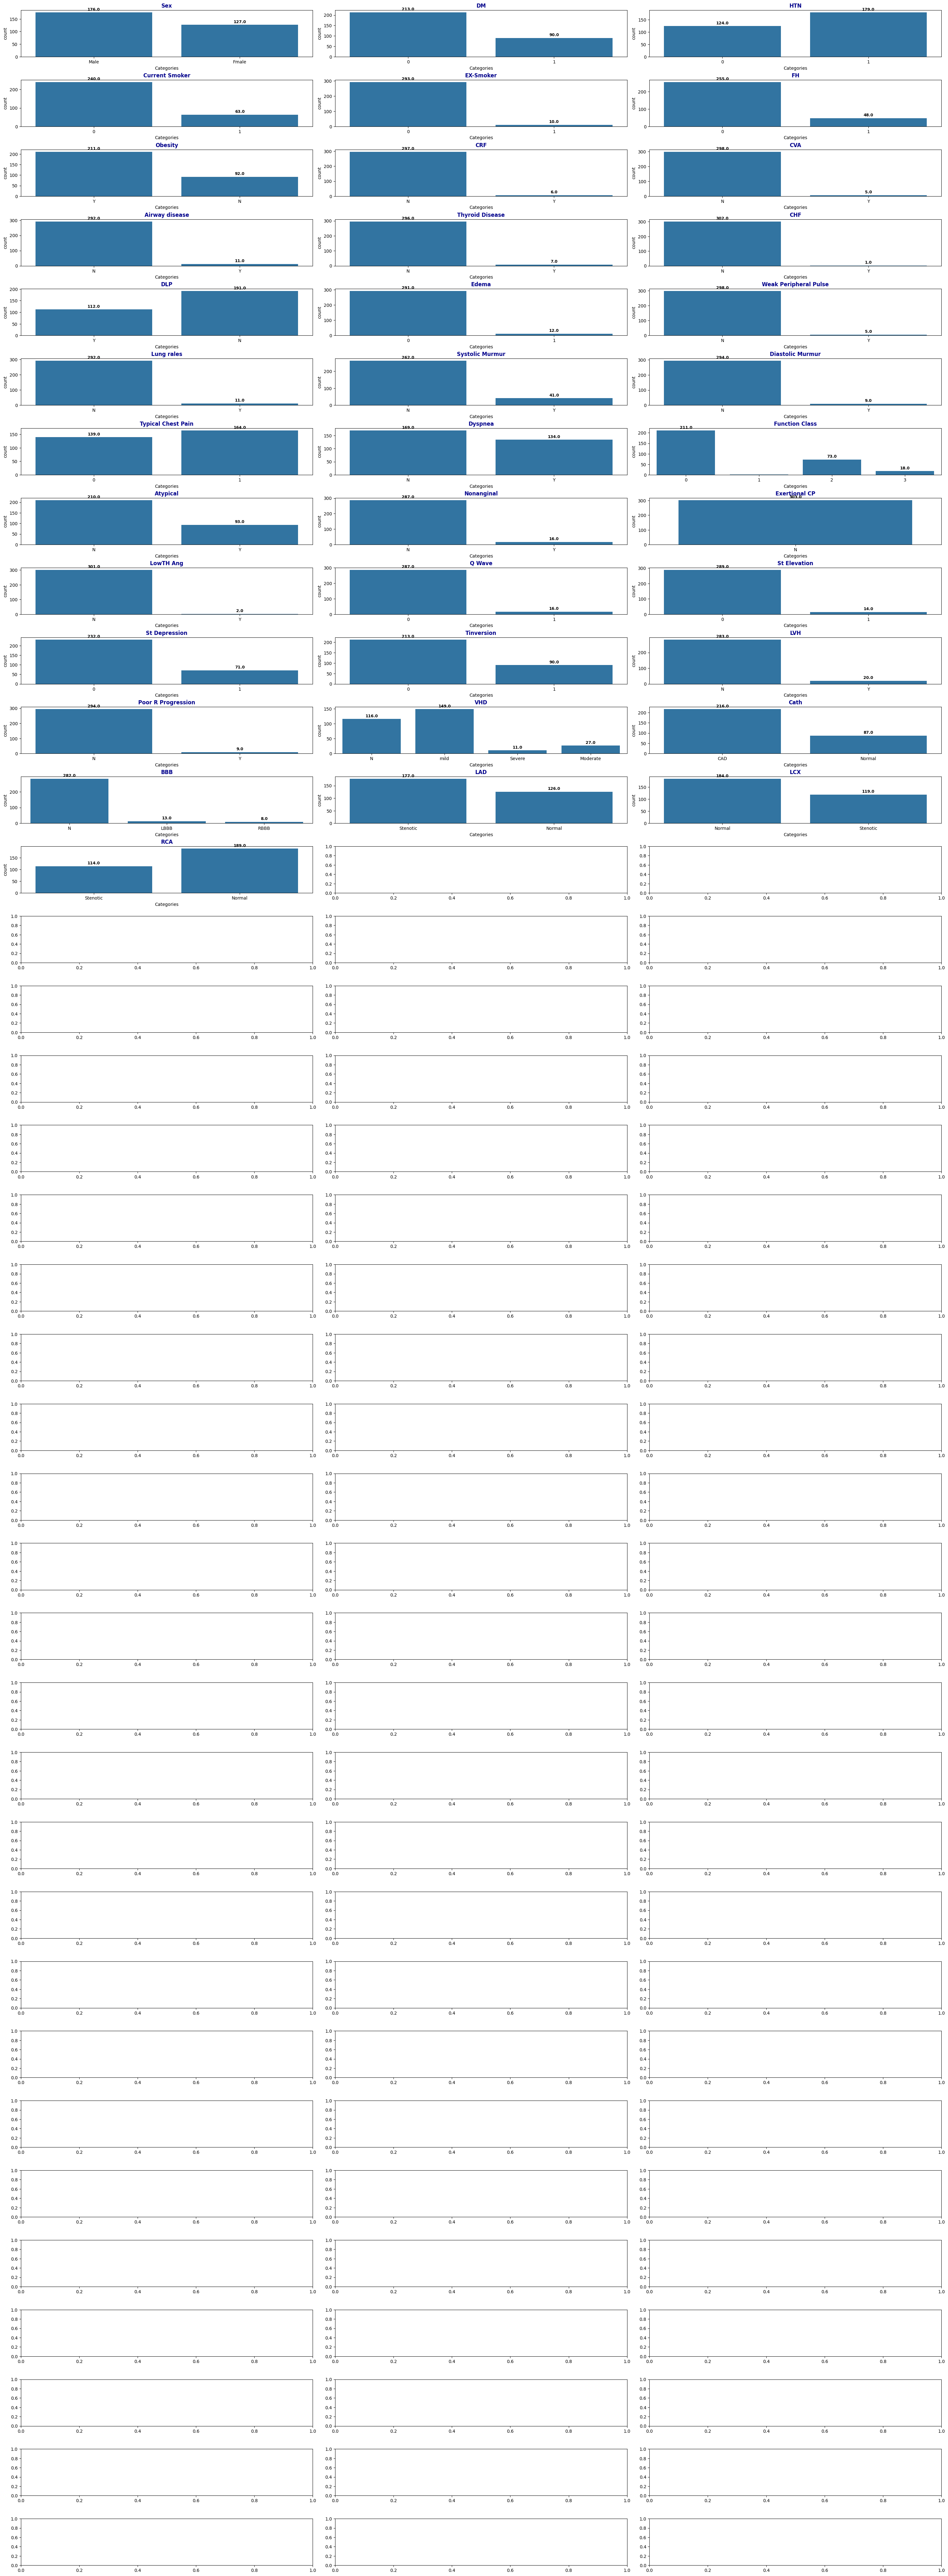

In [10]:
# generate histogram for categorical attributes
fig,ax = plt.subplots(len(categorical_columns),3,figsize = (30,90))
ax = ax.flat

for i,cat_col in enumerate(categorical_columns):
  rects = sns.countplot(df, x = cat_col, ax = ax[i])

  for rect in rects.patches:
      height = rect.get_height()
      ax[i].annotate(f'{height}', (rect.get_x() + rect.get_width() / 2, height-2),
                  xytext=(0, 3),
                  textcoords="offset points",
                  size = 9,
                  ha='center',
                  va='bottom',
                  weight = 'bold')

  ax[i].set_title(f'{cat_col}', fontsize = 12, fontweight = 'bold', color = 'darkblue')
  ax[i].set_xlabel('Categories')


fig.tight_layout()
fig.subplots_adjust(top = 0.9)
fig.show()

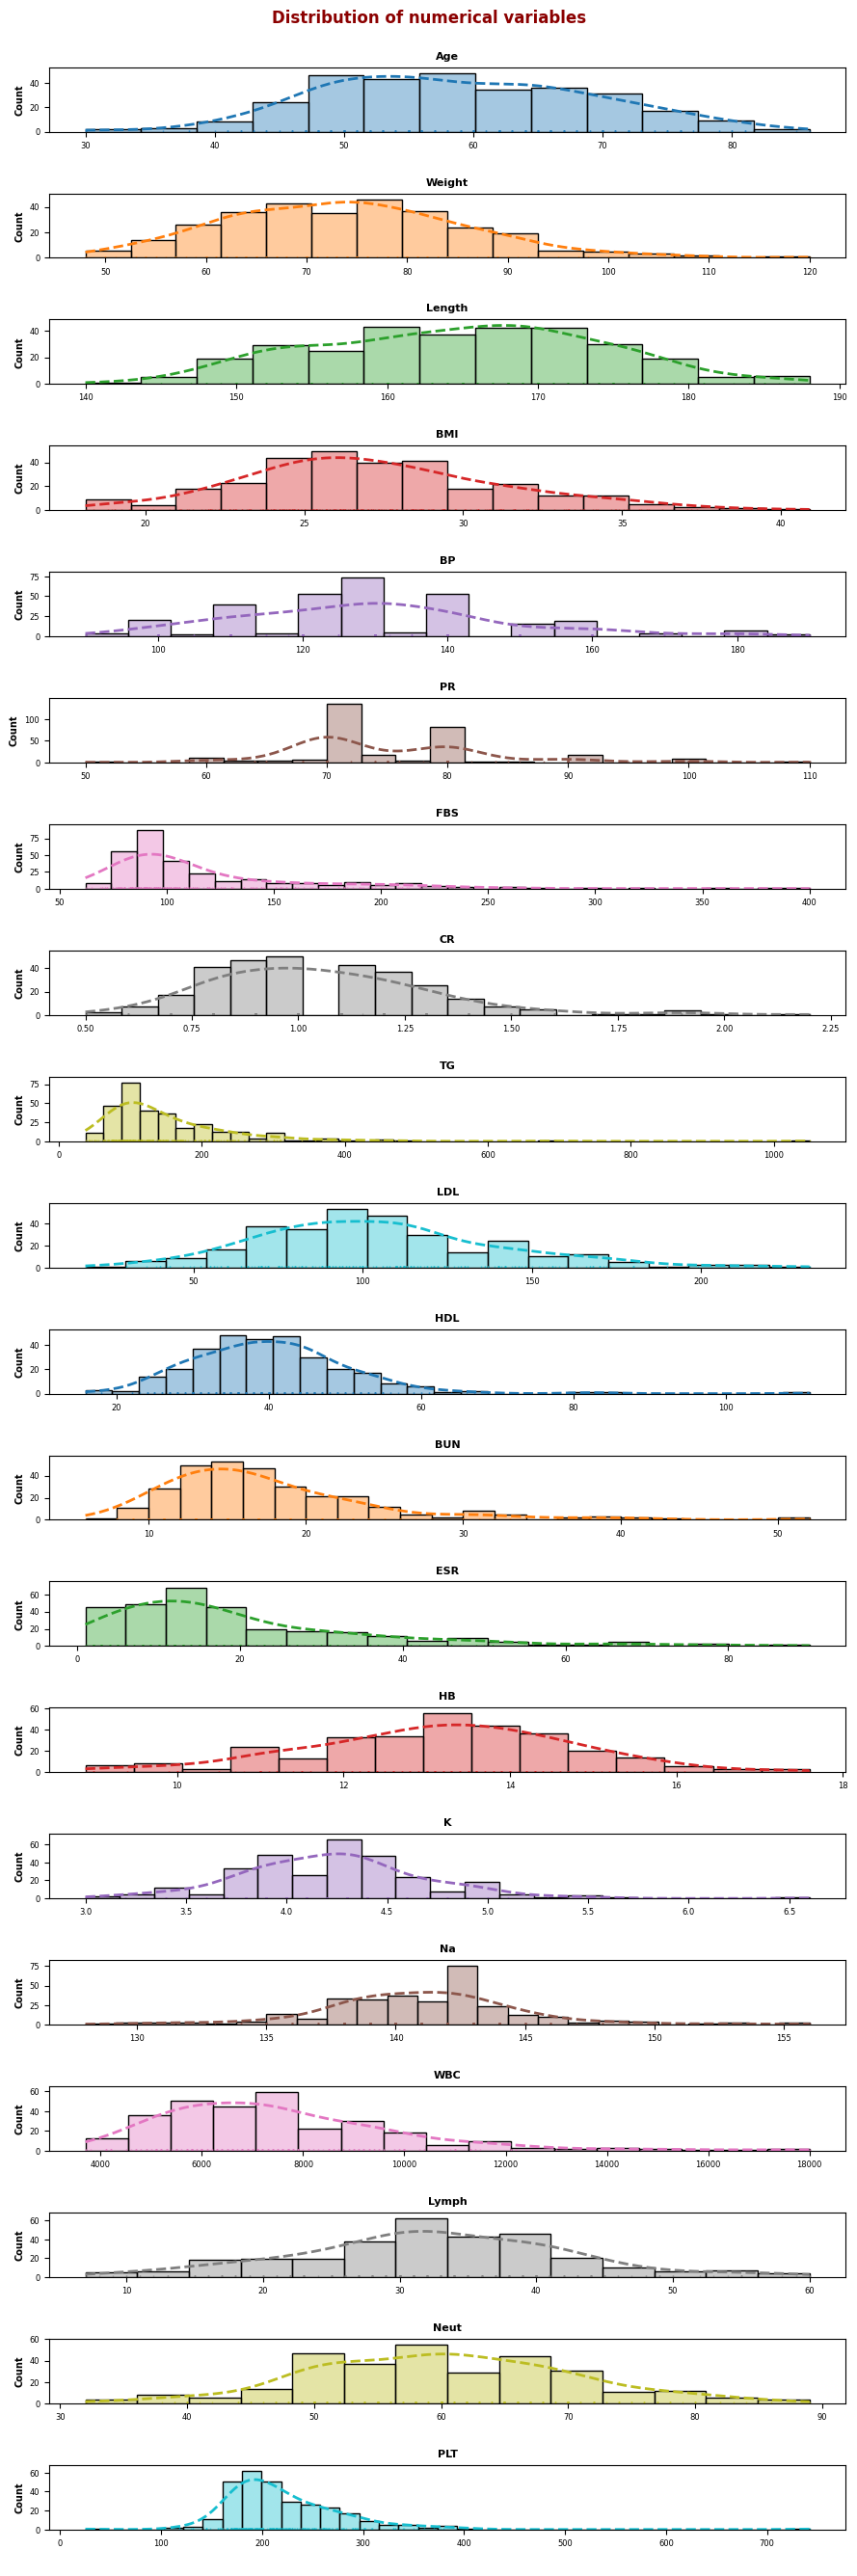

In [11]:
# generate histogram for numerical variables
fig,axes = plt.subplots(nrows = len(numerical_columns), figsize = (9, 30))
axes = axes.flat

color_cycle = list(plt.rcParams['axes.prop_cycle'])
num_colors = len(color_cycle)

for i, num_col in enumerate(numerical_columns):
  sns.histplot(df,
               x = num_col,
               stat = 'count',
               kde = True,
               color = color_cycle[i % num_colors]["color"],
               line_kws = {'linewidth': 2,
                           'linestyle':'dashed'},
               alpha = 0.4,
               ax = axes[i])
  sns.rugplot(df,
              x = num_col,
              color = color_cycle[i % num_colors]["color"],
              ax = axes[i], alpha = 0.7)

  axes[i].set_xlabel(" ")
  axes[i].set_ylabel("Count", fontsize = 7, fontweight = 'bold', color = 'black')
  axes[i].set_title(num_col, fontsize = 8, fontweight = 'bold', color = 'black')
  axes[i].tick_params(labelsize = 6)

fig.delaxes(axes[len(numerical_columns) - 1])
fig.suptitle('Distribution of numerical variables', fontsize = 12, fontweight = 'bold', color = 'darkred', y = 0.92)
fig.tight_layout()
fig.subplots_adjust(top = 0.9)
fig.show()

# 3. Preprocess

---


In [12]:
# mappings
# Sex
sex_map = {
    'Male': 0,
    'Fmale': 1,
}
# Yes and No Map
yn_map = {
    'N': 0, 
    'Y': 1,
}
# VHD Map
vhd_map = {
    'N': 0,
    'mild': 1,
    'Moderate': 2,
    'Severe': 3,
}
# Cath Map
cath_map = {
    'Normal': 0,
    'Cad': 1,
}

In [13]:
yn_features = ['Obesity', 'CRF', 'CVA', 'Airway disease', 'Thyroid Disease', 'CHF', 'DLP', 'Weak Peripheral Pulse', 'Lung rales', 'Systolic Murmur', 'Diastolic Murmur', 'Dyspnea', 'Atypical', 'Nonanginal', 'Exertional CP', 'LowTH Ang', 'LVH', 'Poor R Progression']
for feature in yn_features:
    df[feature] = df[feature].map(yn_map)
df['Sex'] = df['Sex'].map(sex_map)
df['VHD'] = df['VHD'].map(vhd_map)
df['Cath'] = df['Cath'].map(cath_map)
df

,Age,Weight,Length,Sex,BMI,DM,HTN,Current Smoker,EX-Smoker,FH,...,Lymph,Neut,PLT,EF-TTE,Region RWMA,VHD,LAD,LCX,RCA,Cath
0,53,90,175,0,29.387755,0,1,1,0,0,...,39,52,261,50,0,0,Stenotic,Normal,Stenotic,NaN
1,67,70,157,1,28.398718,0,1,0,0,0,...,38,55,165,40,4,0,Stenotic,Stenotic,Normal,NaN
2,54,54,164,0,20.077335,0,0,1,0,0,...,38,60,230,40,2,1,Stenotic,Normal,Normal,NaN
3,66,67,158,1,26.838648,0,1,0,0,0,...,18,72,742,55,0,3,Normal,Normal,Normal,0.0
4,50,87,153,1,37.165193,0,1,0,0,0,...,55,39,274,50,0,3,Normal,Normal,Normal,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,58,84,168,0,29.761905,0,0,0,0,0,...,34,58,251,45,0,0,Stenotic,Stenotic,Stenotic,NaN
299,55,64,152,1,27.700831,0,0,0,0,0,...,16,80,377,40,0,1,Normal,Normal,Normal,0.0
300,48,77,160,1,30.078125,0,1,0,0,1,...,35,55,279,55,0,0,Normal,Normal,Normal,0.0
301,57,90,159,1,35.599858,1,0,0,0,0,...,48,40,208,55,0,0,Normal,Normal,Normal,0.0


In [14]:
## Dat set size
print(f'The data set has {df.shape[0]} rows and {df.shape[1]} columns')
# Generate test and train suites
x_train, x_test, y_VHD_train, y_VHD_test = train_test_split(df.iloc[:, 0:11], df.VHD, test_size=0.2)
_, _, y_cath_train, y_cath_test = train_test_split(df.iloc[:, 0:11], df.Cath, test_size=0.2)

The data set has 303 rows and 59 columns


# 4. Models & Predictions

---


In [15]:
models = {
    'SVC': SVC(),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=5, random_state=0),
    'GaussianNB': GaussianNB(),
    'DecisionTree': DecisionTreeClassifier(),
    'KNeighbors': KNeighborsClassifier(n_neighbors=5),
    'AdaBoost': AdaBoostClassifier(),
    'RandomForest': RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1, random_state=42),
    'MLPClassifier': MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    'GaussianProcess': GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    'QuadraticDiscriminantAnalysis': QuadraticDiscriminantAnalysis()
}

results_VHD = []
results_Cath = []

for model_name, model_object in models.items():
    # fit model 
    model_VHD = model_object.fit(x_train, y_VHD_train)
    model_Cath = model_object.fit(x_train, y_cath_train)

    predictions_VHD = model_VHD.predict(x_test)
    predictions_Cath = model_Cath.predict(x_test)

    print('-'*60)
    print(f'{model_name} - VHD')
    print(f'accuracy: {accuracy_score(predictions_VHD, y_VHD_test)}')
    print(f'balanced accuracy: {balanced_accuracy_score(predictions_VHD, y_VHD_test)}')
    print('-'*60)
    print(f'{model_name} - Cath')
    print(f'accuracy: {accuracy_score(predictions_Cath, y_cath_test)}')
    print(f'balanced accuracy: {balanced_accuracy_score(predictions_Cath, y_cath_test)}')
    print('-'*60)

    results_VHD.append(balanced_accuracy_score(predictions_VHD, y_VHD_test))
    results_Cath.append(balanced_accuracy_score(predictions_Cath, y_cath_test))

ValueError: Input y contains NaN.

# 5. Results

---


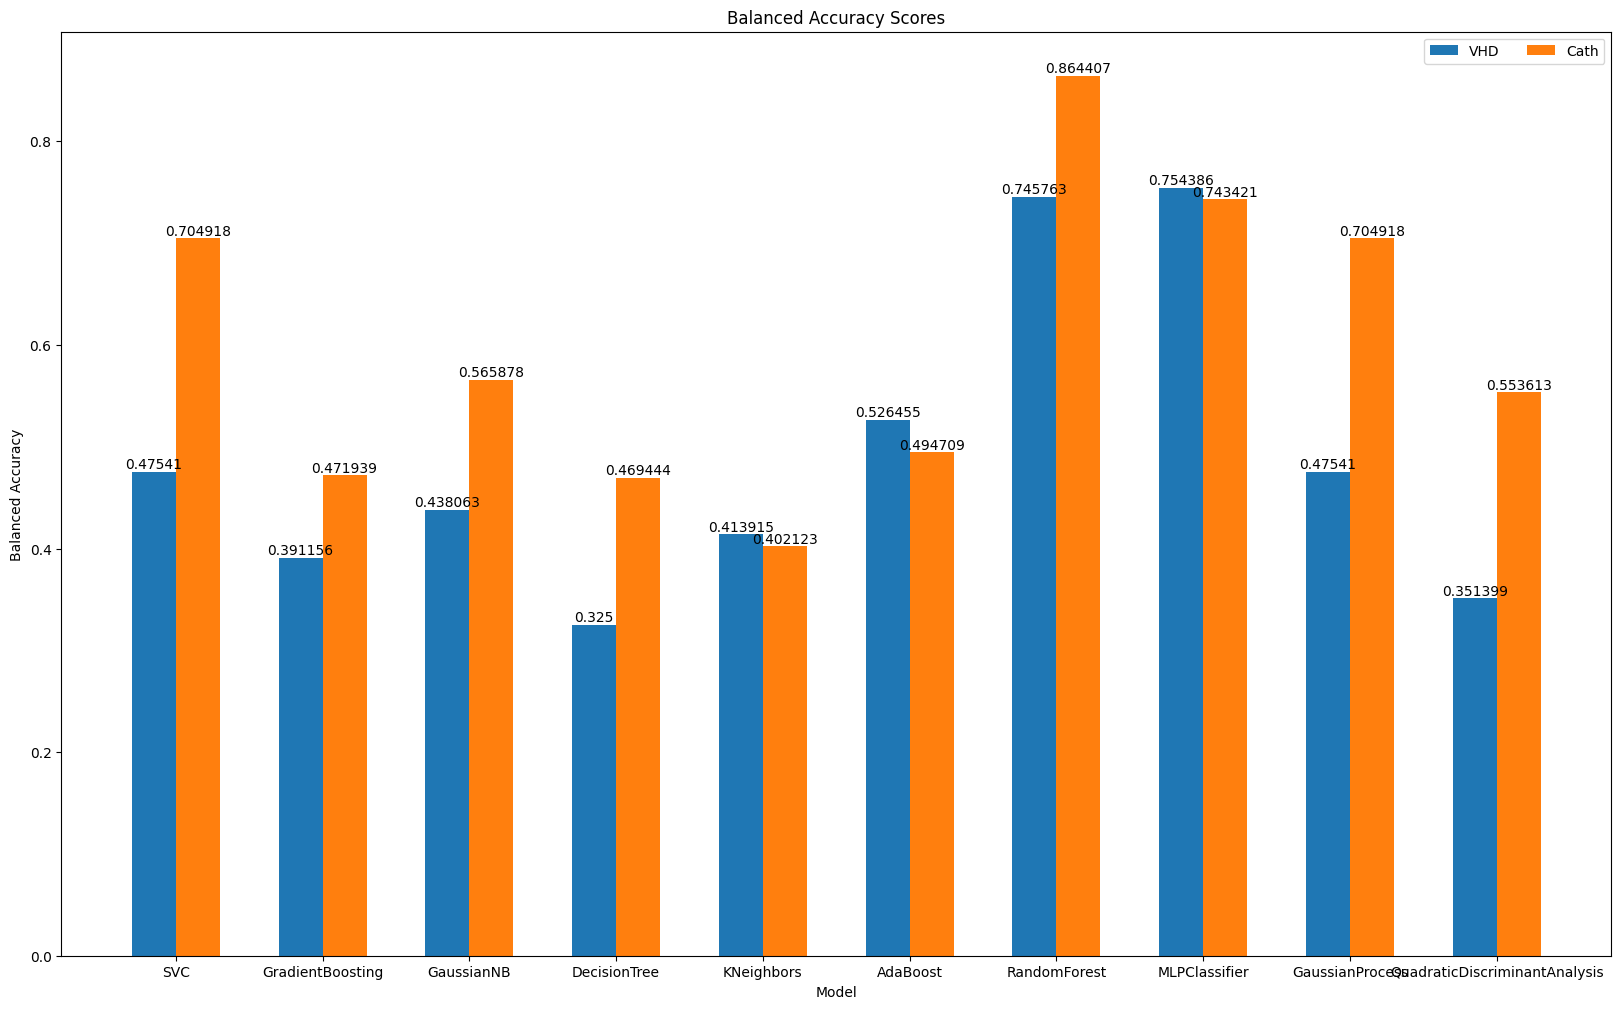

In [ ]:
x_axis = list(models.keys())
y_axis = {
    'VHD': results_VHD,
    'Cath': results_Cath
}

x = np.arange(len(x_axis))  # the label locations
width = 0.3  # the width of the bars
multiplier = 0


fig, ax = plt.subplots()
fig.set_figheight(12)
fig.set_figwidth(20)

for attribute, measurement in y_axis.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=0)

    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Balanced Accuracy')
ax.set_xlabel('Model')
ax.set_title('Balanced Accuracy Scores')
ax.set_xticks(x + width/2, x_axis)
ax.legend(loc='best', ncols=2)

plt.show()